<a href="https://colab.research.google.com/github/lonelygo/awesome-machine-learning-colab-ipynb/blob/master/cars_segmentation_(camvid).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Install required libs
! pip install catalyst==19.04rc1

### please update Albumentations to latest version for `Lambda` transform support
!pip install -U git+https://github.com/albu/albumentations@bdd6a4e
!pip install -U git+https://github.com/qubvel/segmentation_models.pytorch

  Using cached https://files.pythonhosted.org/packages/6c/4b/c38b5144cf167c4f52288517436ccafefe9dc01b8d1c190e18a6b154cd4a/tqdm-4.31.1-py2.py3-none-any.whl
torchvision 0.2.2 has requirement tqdm==4.19.9, but you'll have tqdm 4.31.1 which is incompatible.
  Found existing installation: tqdm 4.19.9
    Uninstalling tqdm-4.19.9:
      Successfully uninstalled tqdm-4.19.9
  Cloning https://github.com/albu/albumentations (to revision bdd6a4e) to /tmp/pip-req-build-iy4qppok
  Did not find branch or tag 'bdd6a4e', assuming revision or ref.
  Stored in directory: /tmp/pip-ephem-wheel-cache-lzc35auw/wheels/c8/4b/1e/8797cb1aeedef8d62984dffbab9dd502fd21a91d2ae146b1ca
Successfully built albumentations
  Found existing installation: albumentations 0.2.2
    Uninstalling albumentations-0.2.2:
      Successfully uninstalled albumentations-0.2.2
  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-smjj_39c
  Using cached https://files.pythonhosted.org/packages/b3/c4/b67

## Loading data

For this example we will use **CamVid** dataset. It is a set of:
 - **train** images + segmentation masks
 - **validation** images + segmentation masks
 - **test** images + segmentation masks
 
All images have 320 pixels height and 480 pixels width.
For more inforamtion about dataset visit http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/.

In [0]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt

In [0]:
DATA_DIR = './data/CamVid/'

# load repo with data if it is not exists
if not os.path.exists(DATA_DIR):
    print('Loading data...')
    os.system('git clone https://github.com/alexgkendall/SegNet-Tutorial ./data')
    print('Done!')

In [0]:
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

In [0]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

### Dataloader

Writing helper class for data extraction, tranformation and preprocessing  
https://pytorch.org/docs/stable/data

In [0]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [0]:
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
               'tree', 'signsymbol', 'fence', 'car', 
               'pedestrian', 'bicyclist', 'unlabelled']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

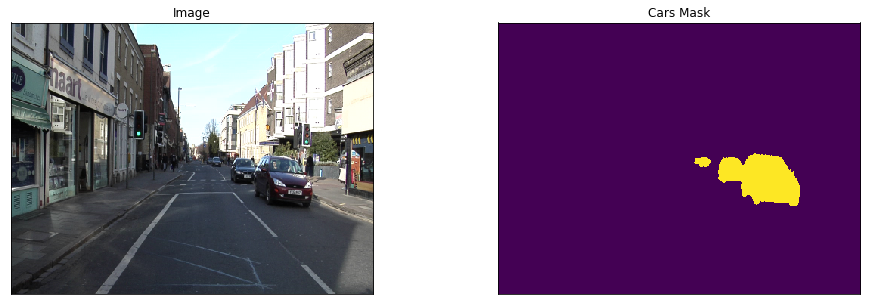

In [0]:
# Lets look at data we have

dataset = Dataset(x_train_dir, y_train_dir, classes=['car'])

image, mask = dataset[4] # get some sample
visualize(
    image=image, 
    cars_mask=mask.squeeze(),
)

### Augmentations

Data augmentation is a powerful technique to increase the amount of your data and prevent model overfitting.  
If you not familiar with such trick read some of these articles:
 - [The Effectiveness of Data Augmentation in Image Classification using Deep
Learning](http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf)
 - [Data Augmentation | How to use Deep Learning when you have Limited Data](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced)
 - [Data Augmentation Experimentation](https://towardsdatascience.com/data-augmentation-experimentation-3e274504f04b)

Since our dataset is very small we will apply a large number of different augmentations:
 - horizontal flip
 - affine transforms
 - perspective transforms
 - brightness/contrast/colors manipulations
 - image bluring and sharpening
 - gaussian noise
 - random crops

All this transforms can be easily applied with [**Albumentations**](https://github.com/albu/albumentations/) - fast augmentation library.
For detailed explanation of image transformations you can look at [kaggle salt segmentation exmaple](https://github.com/albu/albumentations/blob/master/notebooks/example_kaggle_salt.ipynb) provided by [**Albumentations**](https://github.com/albu/albumentations/) authors.

In [0]:
import albumentations as albu

In [0]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        albu.RandomCrop(height=320, width=320, always_apply=True),

        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

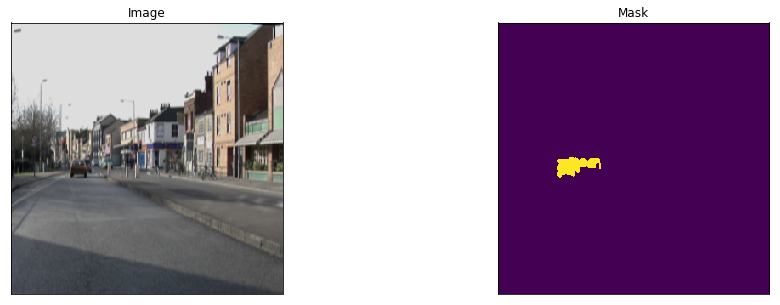

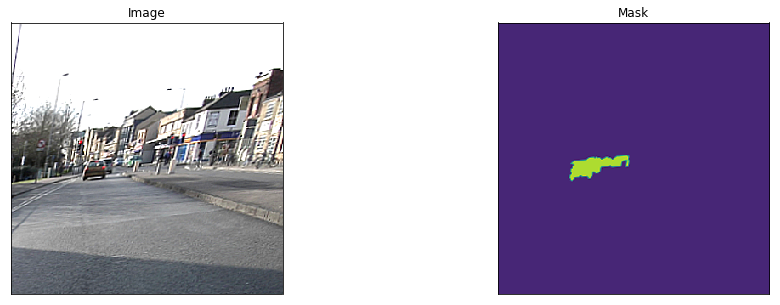

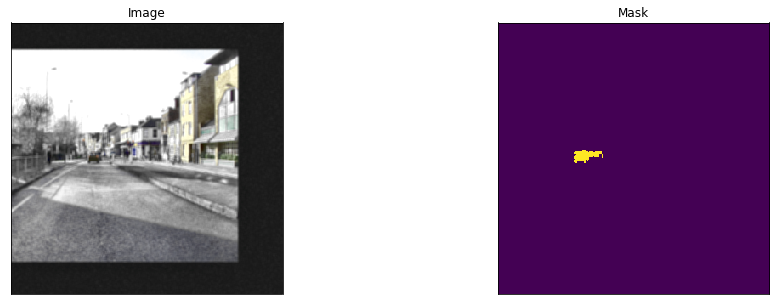

In [0]:
#### Visualize resulted augmented images and masks

augmented_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    classes=['car'],
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[1]
    visualize(image=image, mask=mask.squeeze(-1))

## Create model and train

In [0]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [0]:
ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
DEVICE = 'cuda'

CLASSES = ['car']
ACTIVATION = 'sigmoid'

In [0]:
# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [0]:
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=12)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

/usr/local/lib/python3.6/dist-packages/albumentations/augmentations/transforms.py:1734: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  warnings.warn('Using lambda is incompatible with multiprocessing. '


# Catalyst

## Training

In [0]:
import torch
import torch.nn as nn
from catalyst.dl.experiments import SupervisedRunner

# experiment setup
num_epochs = 10  # change me
logdir = "./logs/segmentation_notebook"
loaders = {
    "train": train_loader,
    "valid": valid_loader
}

# model, criterion, optimizer
# model = # already defined
criterion = smp.utils.losses.BCEDiceLoss(eps=1.)
optimizer = torch.optim.Adam([
    {'params': model.decoder.parameters(), 'lr': 1e-4}, 
    
    # decrease lr for encoder in order not to permute 
    # pre-trained weights with large gradients on training start
    {'params': model.encoder.parameters(), 'lr': 1e-6},  
])
scheduler = None

# @TODO: add metrics support 
# (catalyst expects logits, rather than sigmoid outputs)
# metrics = [
#     smp.utils.metrics.IoUMetric(eps=1.),
#     smp.utils.metrics.FscoreMetric(eps=1.),
# ]


# model runner
runner = SupervisedRunner()

# model training
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    loaders=loaders,
    logdir=logdir,
    num_epochs=num_epochs,
    verbose=False
)

[2019-04-22 08:08:55,472] 
0/10 * Epoch 0 (train): _fps=214.5307 | base/batch_time=0.2776 | base/data_time=0.0368 | base/lr=0.0010 | base/model_time=0.2408 | base/momentum=0.9000 | loss=2.5824
0/10 * Epoch 0 (valid): _fps=45.8127 | base/batch_time=0.0625 | base/data_time=0.0058 | base/lr=0.0010 | base/model_time=0.0567 | base/momentum=0.9000 | loss=2.1113
[2019-04-22 08:09:31,014] 
1/10 * Epoch 1 (train): _fps=216.4891 | base/batch_time=0.1107 | base/data_time=0.0549 | base/lr=0.0010 | base/model_time=0.0558 | base/momentum=0.9000 | loss=1.3381
1/10 * Epoch 1 (valid): _fps=37.1490 | base/batch_time=0.0301 | base/data_time=0.0062 | base/lr=0.0010 | base/model_time=0.0240 | base/momentum=0.9000 | loss=1.2440
[2019-04-22 08:10:05,679] 
2/10 * Epoch 2 (train): _fps=205.4922 | base/batch_time=0.1159 | base/data_time=0.0696 | base/lr=0.0010 | base/model_time=0.0463 | base/momentum=0.9000 | loss=0.9068
2/10 * Epoch 2 (valid): _fps=37.4657 | base/batch_time=0.0298 | base/data_time=0.0060 | bas

### Visualization

In [0]:
from catalyst.dl.utils import UtilsFactory
# you can use plotly and tensorboard to plot metrics inside jupyter
# by default it only plots loss
# not sure if it correctly works in Colab
UtilsFactory.plot_metrics(logdir=logdir)

## Inference

In [0]:
# create test dataset
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset)

/usr/local/lib/python3.6/dist-packages/albumentations/augmentations/transforms.py:1734: UserWarning:

Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().



In [0]:
import collections
from catalyst.dl.callbacks import InferCallback, CheckpointCallback
loaders = {"infer": test_dataloader}
runner.infer(
    model=model,
    loaders=loaders,
    callbacks=[
        CheckpointCallback(
            resume=f"{logdir}/checkpoints/best.pth"),
        InferCallback()
    ],
)

=> loading checkpoint "./logs/segmentation_notebook/checkpoints/best.pth"
loaded checkpoint "./logs/segmentation_notebook/checkpoints/best.pth" (epoch 9)
Top best models:



### Visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


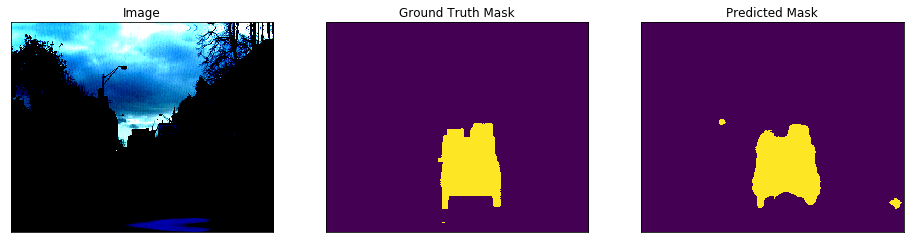

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


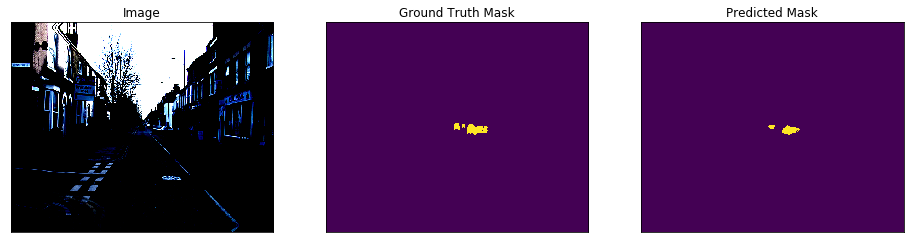

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


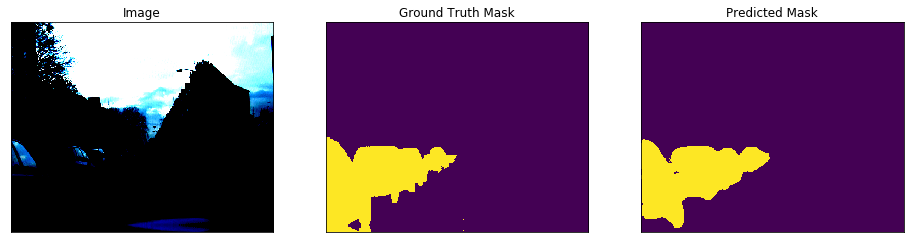

In [0]:
threshold = 0.5
break_at = 2

for i, (input, output) in enumerate(zip(
        test_dataset, runner.callbacks[1].predictions["logits"])):
    image, mask = input
    
    image_vis = image.transpose(1, 2, 0)
    gt_mask = mask[0].astype('uint8')
    pr_mask = (output[0] > threshold).astype('uint8')
        
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )
    
    if i >= break_at:
      break